# Testes - Modelo CNN para Reconhecimento Facial

## Bibliotecas

In [5]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.advanced_activations import LeakyReLU

/Users/jeanlima/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/jeanlima/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Arquitetura da CNN

In [6]:
classifier = Sequential()
classifier.add(Convolution2D(32, kernel_size=(3, 3),activation='linear',input_shape=(64,64,3),padding='same'))
classifier.add(Dropout(0.2))
classifier.add(MaxPooling2D((2, 2),padding='same'))
classifier.add(Convolution2D(64, (3, 3), activation='linear',padding='same'))
classifier.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
classifier.add(Convolution2D(128, (3, 3), activation='linear',padding='same'))
classifier.add(LeakyReLU(alpha=0.1))  
classifier.add(Dropout(0.2))
classifier.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
classifier.add(Flatten())
classifier.add(Dense(128, activation='linear'))
classifier.add(Dropout(0.5))
classifier.add(LeakyReLU(alpha=0.1))                  
classifier.add(Dense(3, activation='softmax'))

In [7]:
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Dataset

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
training_set = train_datagen.flow_from_directory(
        'dataset',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'dataset-test',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

Found 69 images belonging to 3 classes.
Found 10 images belonging to 3 classes.


## Treino e Teste

In [10]:
epochs = 5

history = classifier.fit_generator(
        training_set,
        steps_per_epoch=69//8,
        epochs=epochs,
        validation_data=test_set,
        validation_steps=15//8,
        verbose = 1)

Epoch 1/5
8/8 [==============================] - 4s 448ms/step - loss: 0.7643 - acc: 0.6528 - val_loss: 0.1393 - val_acc: 1.0000
Epoch 2/5
8/8 [==============================] - 2s 233ms/step - loss: 0.0373 - acc: 0.9958 - val_loss: 4.1504e-05 - val_acc: 1.0000
Epoch 3/5
8/8 [==============================] - 2s 305ms/step - loss: 0.0307 - acc: 0.9879 - val_loss: 8.9110e-06 - val_acc: 1.0000
Epoch 4/5
8/8 [==============================] - 2s 265ms/step - loss: 0.0492 - acc: 0.9730 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 5/5
8/8 [==============================] - 2s 305ms/step - loss: 0.0454 - acc: 0.9839 - val_loss: 1.7441e-05 - val_acc: 1.0000


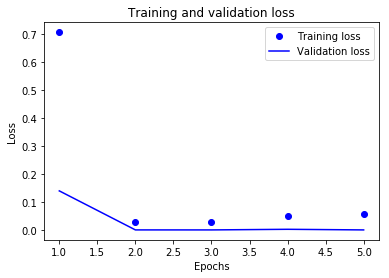

In [12]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs_x = range(1,  epochs+1)
plt.plot(epochs_x, loss_values, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

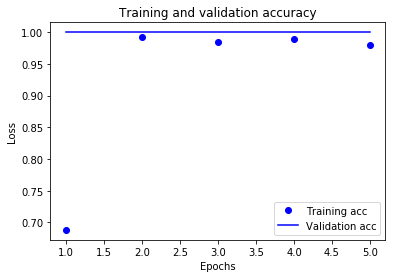

In [13]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs_x, acc_values, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Resultados

In [16]:
import pandas as pd
import numpy as np
predict_gen = test_datagen.flow_from_directory(directory='dataset-test',
                                                              target_size=[64,64],
                                                              batch_size=4123,
                                                              class_mode='categorical')

X_val_sample, res = next(predict_gen)
y_pred = classifier.predict(X_val_sample)
#classifier.evaluate_generator(test_datagen, steps=1, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
onedtrue = []
onedpred = []
for true, pred in zip(res, y_pred):
    onedtrue.append(np.argmax(true))
    onedpred.append(np.argmax(pred))
    
from sklearn.metrics import confusion_matrix
print(confusion_matrix(onedtrue, onedpred))

from sklearn.metrics import classification_report
target_names = ['Jean', 'Karen', 'Thay']

print(classification_report(onedtrue, onedpred, target_names=target_names))

Found 15 images belonging to 3 classes.
[[5 0 0]
 [0 5 0]
 [0 0 5]]
              precision    recall  f1-score   support

        Jean       1.00      1.00      1.00         5
       Karen       1.00      1.00      1.00         5
        Thay       1.00      1.00      1.00         5

   micro avg       1.00      1.00      1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



In [7]:
classifier.save('classifier-100.h5')

## Teste - Rotina de Reconhecimento

In [22]:
#iniciate id counter
id = 0

# names related to ids: example ==> Marcelo: id=1,  etc
names = ['Jean', 'Karen', 'Thay'] 
test_datagen = ImageDataGenerator(rescale=1./255)
import cv2
import os

cam = cv2.VideoCapture(0)
cam.set(3, 640) # set video width
cam.set(4, 480) # set video height

# Frontal faces pattern
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while(True):

    ret, img = cam.read()
    img = cv2.flip(img, 1) # flip video image vertically
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:

        cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)     

        # Save the captured image into the datasets folder
        cv2.imwrite("images/img/face.jpg", gray[y:y+h,x:x+w])
#         cv2.imshow('image', img)
        
        predict_gen = test_datagen.flow_from_directory(directory='images/',
                                                              target_size=[64,64],
                                                              batch_size=4123,
                                                              class_mode='categorical')

        X_val_sample, res = next(predict_gen)
        y_pred = classifier.predict_proba(X_val_sample)

        for i in range(len(y_pred)):
            for j in range(len(y_pred[i])):
                if (y_pred[i][j]==max(y_pred[i])):
                    print(names[j], '-', max(y_pred[i]))
        
    # Press 'ESC' for exiting video
    k = cv2.waitKey(100) & 0xff 
    if k == 27:
        print('ESC')
        break

cam.release()
cv2.destroyAllWindows()

Found 1 images belonging to 1 classes.
Jean - 0.6562382
Found 1 images belonging to 1 classes.
Jean - 0.7089095
Found 1 images belonging to 1 classes.
Jean - 0.76551753
Found 1 images belonging to 1 classes.
Jean - 0.86719835
Found 1 images belonging to 1 classes.
Jean - 0.98045427
Found 1 images belonging to 1 classes.
Thay - 0.99895465
Found 1 images belonging to 1 classes.
Jean - 0.6571985
Found 1 images belonging to 1 classes.
Jean - 0.6787315
Found 1 images belonging to 1 classes.
Jean - 0.6925486
Found 1 images belonging to 1 classes.
Jean - 0.764894
Found 1 images belonging to 1 classes.
Jean - 0.54025614
Found 1 images belonging to 1 classes.
Jean - 0.6858827
Found 1 images belonging to 1 classes.
Jean - 0.65055656
Found 1 images belonging to 1 classes.
Jean - 0.6353309
Found 1 images belonging to 1 classes.
Jean - 0.65264887
Found 1 images belonging to 1 classes.
Jean - 0.68535954
Found 1 images belonging to 1 classes.
Jean - 0.656801
Found 1 images belonging to 1 classes.
Kar

KeyboardInterrupt: 

In [23]:
cam.release()
cv2.destroyAllWindows()